# Binary Neural Networks

Existing deep neural networks use 32 bits, 16 bits or 8 bits to encode each weight and activation, making them large, slow and power-hungry. This prohibits many applications in resource-constrained environments.

Binary Neural Network is a type of neural network that activations (or called features) and weights are 1-bit values in all the hidden layers (except the input and output layers). In a few words, BNN is an extremely compacted case of CNN - they have the same structures except for the different precision activations and weights. The use of BNNs enables not only significant reduction in memory usage, but also huge computational complexity improvements - the replacement of multiply-accumulation operations by `XNOR` and `bitcount` operations.

Today, we'll use `Larq` - an open-source Python library for training neural networks with extremely low-precision weights and activations.

You can find out more here: https://docs.larq.dev/larq/

Larq is build on top of `TensorFlow` which is Python library for training neural networks, just like `PyTorch`. Because of that, we need to get familiar with this framework.

First, install and import nessessery libraries.

In [1]:
!pip install larq larq-zoo larq-compute-engine
!pip install tensorflow==2.10.0

In [2]:
import tensorflow as tf
import larq as lq

We'll stick with simple 3-conv-layers CNN and MNIST dataset. This time, we'll implement it with `TensorFlow`

First, we use `tf.keras.datasets.mnist.load_data()` to download a dataset. Then, we need to reshape images to `(numer_of_samples, image_width, image_height, number_of_channels)`. Finally, we normalize image values to be between -1 and 1.

In [3]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Reshape the images to add a channel dimension (in MNIST, 1 because images are grayscale)
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# Normalize the images to [-1, 1]
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

Now, we need to create our model. We'll use the same architecture as in `PyTorch`:

```
nn.Conv2d(input_channels,32,3,padding=(1,1))
nn.BatchNorm2d(32)
nn.ReLU()
nn.MaxPool2d(2,2)

nn.Conv2d(32,64,3,padding=(1,1))
nn.BatchNorm2d(64)
nn.ReLU()
nn.MaxPool2d(2,2)

nn.Conv2d(64,128,3)
nn.BatchNorm2d(128)
nn.ReLU()

nn.Flatten(),
nn.Linear(CNN_out_size, num_of_cls),
nn.Softmax(dim=1)
```

In `TensorFlow` however we define model with `tf.keras.models.Sequential()` and then we add layers one by one with `model.add()`.

Create model with the help of documentation (https://keras.io/api/layers/) and following tips. You're going to need following layers:

- In `PyTorch` we created convolutional layers with `Conv2d(in_ch, out_ch, kernel_size, padding=(x,x))`.  For `TrensorFlow` we use `tf.keras.layers.Conv2D(out_ch, kernel_size, strides=(x,x), padding="same")`.
- For `stride=(x,x)` and `padding="same"` we get the same result as with `padding=(x,x)` in PyTorch. We don't have to specify number of input channels, but we have to specify `input_shape=(w,h,ch)` parameter for the first `Conv2D` layer.
- The activation function is not added as a additional layer, but as `activation="relu"` parameter to `Conv2D`
- You'll need `tf.keras.layers.BatchNormalization(scale=False)`, `tf.keras.layers.MaxPooling2D((2, 2))`, `tf.keras.layers.Dense(output_size)` and `tf.keras.layers.Flatten()` layers.
- The last layer (softmax) in our model should be `tf.keras.layers.Activation("softmax")`

In [4]:
CNN = tf.keras.models.Sequential()

# First convolutional block
CNN.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)))
CNN.add(tf.keras.layers.BatchNormalization())
CNN.add(tf.keras.layers.ReLU())
CNN.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Second convolutional block
CNN.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
CNN.add(tf.keras.layers.BatchNormalization())
CNN.add(tf.keras.layers.ReLU())
CNN.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Third convolutional block
CNN.add(tf.keras.layers.Conv2D(128, (3, 3), padding='valid'))
CNN.add(tf.keras.layers.BatchNormalization())
CNN.add(tf.keras.layers.ReLU())

# Flatten and dense layers
CNN.add(tf.keras.layers.Flatten())
# The number of neurons in the linear layer (CNN_out_size) depends on the output of the last conv layer
# Let's calculate CNN_out_size
CNN_out_size = (28 // (2 * 2)) * (28 // (2 * 2)) * 128  # 28x28 is the input size and 2x2 pooling is applied twice
num_of_cls = 10  # number of classes for MNIST
CNN.add(tf.keras.layers.Dense(CNN_out_size))
CNN.add(tf.keras.layers.Dense(num_of_cls, activation='softmax'))

Hopefully, we have our network ready to go! You can use `CNN.summary()` function to see our ready network with it's shapes and parameters.

In [5]:
lq.models.summary(CNN)

+sequential stats-----------------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 32-bit    Memory  32-bit MACs |
|                              (bit)                         x 1      (kB)              |
+---------------------------------------------------------------------------------------+
| conv2d                           -  (-1, 28, 28, 32)       320      1.25       225792 |
| batch_normalization              -  (-1, 28, 28, 32)        64      0.25            0 |
| re_lu                            -  (-1, 28, 28, 32)         0         0            ? |
| max_pooling2d                    -  (-1, 14, 14, 32)         0         0            0 |
| conv2d_1                         -  (-1, 14, 14, 64)     18496     72.25      3612672 |
| batch_normalization_1            -  (-1, 14, 14, 64)       128      0.50            0 |
| re_lu_1                          -  (-1, 14, 14, 64)         0         0            ? |
| max_pool

Now, let's train our network! After defining model layers and connections we need to compile it with `model.compile()` function. Google it and study its arguments. We should use `adam` optimizer, `[’accuracy’]`
metric and `tf.keras.losses.SparseCategoricalCrossentropy` loss.

Then, we run training with `model.fit()` function. Google it and study its arguments. We'll train `CNN` with batch size of `64` for `5` epochs with `train_images` and `train_labels`. After training, evaluate network with `CNN.evaluate()`, where you pass only `test_images` and `test_labels`. Print the resulting accuracy. It should be around 99%!

In [6]:
# Compile the model
CNN.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
CNN.fit(
    train_images, 
    train_labels, 
    batch_size=64, 
    epochs=5
)

# Evaluate the model
test_loss, test_acc = CNN.evaluate(test_images, test_labels)

# Print the accuracy
print(f"Test accuracy: {test_acc*100:.2f}%")


Epoch 1/5


c:\Users\krzys\Documents\GitHub\Wbudowane-systemy-AI\.venv\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


938/938 [==============================] - 136s 144ms/step - loss: 0.5541 - accuracy: 0.9538
Epoch 2/5
938/938 [==============================] - 133s 141ms/step - loss: 0.1540 - accuracy: 0.9746
Epoch 3/5
938/938 [==============================] - 138s 147ms/step - loss: 0.1293 - accuracy: 0.9810
Epoch 4/5
938/938 [==============================] - 154s 165ms/step - loss: 0.0780 - accuracy: 0.9848
Epoch 5/5
313/313 [==============================] - 6s 19ms/step - loss: 0.0471 - accuracy: 0.9895
Test accuracy: 98.95%


In [14]:
# Save the model
CNN.save('mnist_cnn.h5')

We got familiar with `TensorFlow` basics and we can carry on with BNNs.

Create new model with `tf.keras.models.Sequential()` and call it `BNN`. Use `model.add()` function to add all nessesery layers to this model. However, you'll need to replace all `Conv2D` and `Dense` layers with their binary counterparts. Use `lq.layers.QuantConv2D()` instead of `tf.keras.layers.Conv2D()` and `lq.layers.QuantDense()` instead of `tf.keras.layers.Dense()`.

They use more or less the same parameters, but additionally, you have to update thair quantizers. In BNNs, the quantization function
$$
q(x) = \begin{cases}
    -1 & x < 0 \\\
    1 & x \geq 0
\end{cases}
$$
is used in the forward pass to binarize the activations and the latent full precision weights. The gradient of this function is zero almost everywhere which prevents the model from learning.

To be able to train the model the gradient is instead estimated using the Straight-Through Estimator (STE):
$$
\frac{\partial q(x)}{\partial x} = \begin{cases}
    1 & \left|x\right| \leq 1 \\\
    0 & \left|x\right| > 1
\end{cases}
$$

In Larq this can be done by using `input_quantizer="ste_sign"` and `kernel_quantizer="ste_sign"`.
Additionally, the latent full precision weights are clipped to -1 and 1 using `kernel_constraint="weight_clip"`.

For the first Conv2d layer add parameters `kernel_quantizer="ste_sign"` and `kernel_constraint="weight_clip"`. For the next ones (both `QuantConv2D` and `QuantDense`) use those two and `input_quantizer="ste_sign"`. This is why we don't quantize the inputs to the first convolutional layer (as is common for BNN training). All other layers should stay the same as in `CNN`.

In [7]:
BNN = tf.keras.models.Sequential()

# First binary convolutional layer
# We only quantize the kernel and not the input for the first layer
BNN.add(lq.layers.QuantConv2D(
    32, (3, 3), 
    padding='same', 
    input_shape=(28, 28, 1),
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip"
))
BNN.add(tf.keras.layers.BatchNormalization())
BNN.add(tf.keras.layers.ReLU())
BNN.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Second binary convolutional layer
BNN.add(lq.layers.QuantConv2D(
    64, (3, 3), 
    padding='same', 
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip"
))
BNN.add(tf.keras.layers.BatchNormalization())
BNN.add(tf.keras.layers.ReLU())
BNN.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Third binary convolutional layer
BNN.add(lq.layers.QuantConv2D(
    128, (3, 3),
    padding='valid', 
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip"
))
BNN.add(tf.keras.layers.BatchNormalization())
BNN.add(tf.keras.layers.ReLU())

# Flatten the outputs for the dense layers
BNN.add(tf.keras.layers.Flatten())

# First binary dense layer
BNN.add(lq.layers.QuantDense(
    CNN_out_size, 
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip"
))

# Second binary dense (output) layer
BNN.add(lq.layers.QuantDense(
    num_of_cls, 
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip",
    activation='softmax'
))


You can use `lq.models.summary(BNN)` function to see our ready network with it's shapes and parameters. Study the quantization summary at the bottom.

In [8]:
lq.models.summary(BNN)

+sequential_1 stats------------------------------------------------------------------------------------------+
| Layer                  Input prec.           Outputs   # 1-bit  # 32-bit   Memory  1-bit MACs  32-bit MACs |
|                              (bit)                         x 1       x 1     (kB)                          |
+------------------------------------------------------------------------------------------------------------+
| quant_conv2d                     -  (-1, 28, 28, 32)       288        32     0.16           0       225792 |
| batch_normalization_3            -  (-1, 28, 28, 32)         0        64     0.25           0            0 |
| re_lu_3                          -  (-1, 28, 28, 32)         0         0        0           ?            ? |
| max_pooling2d_2                  -  (-1, 14, 14, 32)         0         0        0           0            0 |
| quant_conv2d_1                   1  (-1, 14, 14, 64)     18432        64     2.50     3612672            0 |
|

Now, compile, fit for 5 epochs and evaluate your `BNN` (the same way as before). Print the result. Is such a network enough for such a task?

In [9]:
# Compile the BNN model
BNN.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Fit the BNN model
BNN.fit(
    train_images, 
    train_labels, 
    batch_size=64, 
    epochs=5
)

# Evaluate the BNN model
test_loss, test_acc = BNN.evaluate(test_images, test_labels)

# Print the accuracy
print(f"Test accuracy: {test_acc*100:.2f}%")


Epoch 1/5
938/938 [==============================] - 252s 267ms/step - loss: 126.8767 - accuracy: 0.1023
Epoch 2/5
938/938 [==============================] - 244s 260ms/step - loss: 120.1730 - accuracy: 0.1006
Epoch 3/5
938/938 [==============================] - 247s 263ms/step - loss: 112.3871 - accuracy: 0.1023
Epoch 4/5
938/938 [==============================] - 258s 275ms/step - loss: 111.4785 - accuracy: 0.0987
Epoch 5/5
313/313 [==============================] - 20s 62ms/step - loss: 51.7151 - accuracy: 0.0982
Test accuracy: 9.82%


**Extenction exercise**

Deploy this network for ARM-based board (like RaspberryPI) or Android app with Larq Compute Engine. Benchmark it's performance.

Find out more here: https://docs.larq.dev/compute-engine/

# Spiking Neural Networks

Spiking Neural Networks (SNNs) are a type of artificial neural network that is designed to simulate the behavior of neurons in the brain. In a traditional artificial neural network (ANN), the neurons are modeled as having a continuous activation value that changes over time, whereas in an SNN, the neurons are modeled as having discrete "spikes" of activation that occur at specific
points in time.

SNNs are inspired by the way the neurons in the brain work. In the brain, neurons communicate with each other by sending electrical pulses, or spikes, along their axons. These spikes propagate to the dendrites of other neurons and, if the total input to a neuron exceeds a certain threshold, the neuron will generate a spike in response. SNNs use a similar concept: the neurons
in an SNN have a threshold, and if the total input to a neuron exceeds that threshold, the neuron will generate a spike.

SNNs have several advantages over traditional ANNs. One of the main advantages is that SNNs are more energy efficient, because they only communicate when they need to, instead of continuously sending signals. Additionally, SNNs can be more robust to noise and other disturbances, because they can use the timing of spikes to communicate information. Currently SNNs are not as popular as traditional neural networks (ANNs) in industry and research, because of their higher complexity, specialized hardware requirements and less mature toolkits.

SNN takes a set of spikes as input and produces a set of spikes as output. The general idea is:
- Each neuron has a value that is equivalent to the electrical potential of biological neurons at any given time.
- The value of a neuron can change according to its mathematical model; for example, if a neuron gets a spike from an upstream neuron, its value may rise or fall.
- If a neuron’s value surpasses a certain threshold, the neuron will send a single impulse to each downstream neuron connected to the first one, and the neuron’s value will immediately drop below its average.
- As a result, the neuron will go through a refractory period similar to that of a biological neuron. The neuron’s value will gradually return to its average over time.

We'll use `SnnTorch` framework. We'll not dive deep into this idea, we'll just get familiar with the basics. SNNs are very tricky to train, and their research field is still quite new. Moreover, they need state-of-the-art neuromorphic computing platforms like Brainchip's Akida or Intel's Loihi.

Read more here: https://snntorch.readthedocs.io/en/latest/index.html

First, install and import libraries:

In [10]:
!pip install tonic --quiet
!pip install snntorch --quiet
import tonic
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn
import torch
from torch.utils.data import DataLoader

Let's start our journey with the input spikes. Neuromorphic NNs work best with... neuromorphic sensors like Event Cameras.

An event camera (also known as Dynamic Vision Sensor – DVS) is a neuromorphic sensor that takes its inspiration from the human eye. Unlike classical cameras, which record the brightness (colour) level for a given pixel every specified time interval (frame per second parameter), a DVS records brightness changes independently (asynchronously) for individual pixels. Consequently, the data captured by the camera does not depend on the clock but the dynamics of the scene. As a result, a stream of events is available on the output, where each is described by 4 values:
* x & y co-ordinates correspond to an address in a $34 \times 34$ grid.

* The timestamp of the event is recorded in microseconds.

* The polarity refers to whether an on-spike (+1) or an off-spike (-1) occured; i.e., an increase in brightness or a decrease in brightness.

We can use an output of DVS as input to SNN (with some basics transformation, but it does not metter for now). In this task we'll use NMNIST dataset, with is just MNIST dataset recorded with event camera.

Use the following code to download a NMNIST dataset and visualise it. What we can see is the events captured for each pixel (x, y) in time. The colour means a postive or negative polarity.

  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./data\NMNIST\test.zip to ./data\NMNIST


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


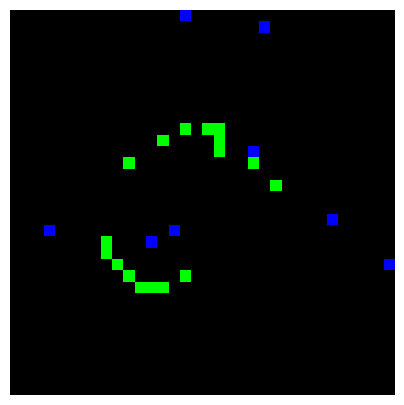

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [11]:
nmnist = tonic.datasets.NMNIST(save_to='./data', train=False)

events, label = nmnist[0]
transform = tonic.transforms.ToFrame(
    sensor_size=nmnist.sensor_size,
    time_window=10000,
)
frames = transform(events)
animation = tonic.utils.plot_animation(frames)

# Display the animation inline in a Jupyter notebook
from IPython.display import HTML
HTML(animation.to_jshtml())

During this task, we'll not train the network. We'll use already pretrained model (from UPEL). Use following line to upload `snn.pth` file, and then run cells with the SNN definition and loading of the weights.

In [12]:
#from google.colab import files
#files.upload()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(12, 32, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    )

testset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=transform, train=False)
testloader = DataLoader(testset, batch_size=1, collate_fn=tonic.collation.PadTensors(batch_first=False))
net.load_state_dict(torch.load("snn.pth"))

  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./tmp/data\NMNIST\test.zip to ./tmp/data\NMNIST


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

Now, let's study the output of the SNN. As we already now, the output is spiking as well. We remeber, that for CNNs the output for MNIST classification is a 10-values vector, where each value refers to the probability, that the object belongs to each class.

For SNNs we have a 10-values vector as well, but each can only be active or inactive (0 or 1). So how can we tell, to which class does the object belongs? We just count the number of spikes registered for each class!

In the following code, we take a sample from dataset, we perform the forward-pass and visualize the output. Study it!

In [ ]:
def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

event_tensor, target = next(iter(testloader))
spk_rec = forward_pass(net, event_tensor)
idx = 0
fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {target}")
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=5)
HTML(anim.to_html5_video())

That's it! There were not much for you to do in this part of the class. The teacher will ask you few questions about SNNs just to verify, that you got the general idea :)